# Setup

Install tensorflow and tensorflow quantum if necessary.

In [26]:
%load_ext autoreload

In [27]:
!pip install tensorflow==2.7.0


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [28]:
!pip install tensorflow-quantum==0.7.2


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [29]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/home/hpn/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py'>

Import tensorflow and the module dependencies:

In [30]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

from tqdm import trange
import pickle

# Results

In [31]:
%autoreload 2

We create three different stilted dataset from fashion MNIST through three CQCA-based quantum models and attempt to learn each with the other.
In the following we illustrate the models.

In [32]:
from model.pqca import PQCACirc

# Global params
NUM_QUBITS = 4
QUBITS = cirq.GridQubit.rect(1, NUM_QUBITS)
OBSERVABLES = [cirq.Z(QUBITS[0])]
NUM_LAYERS_ENC = 1

# Model C params 
NUM_LAYERS_VAR_C = 4
SINGLE_PARAM_C = False
CQCA_C = [["CZ1", "H"]]

variational_c = PQCACirc(QUBITS, NUM_LAYERS_VAR_C, CQCA_C, OBSERVABLES, SINGLE_PARAM_C)
print(variational_c.circuit)
print()
print()

# Model CF params
NUM_LAYERS_VAR_CF = 4
SINGLE_PARAM_CF = False
CQCA_CF = [["H", "S", "H", "S", "CZ1"]] #[["CZ1", "S", "H", "S", "H"]]

variational_cf = PQCACirc(QUBITS, NUM_LAYERS_VAR_CF, CQCA_CF, OBSERVABLES, SINGLE_PARAM_CF)
print(variational_cf.circuit)
print()

# Model CP params
NUM_LAYERS_VAR_CP = 4
SINGLE_PARAM_CP = False
CQCA_CP = [["CZ1", "H"], ["H"]]

variational_c = PQCACirc(QUBITS, NUM_LAYERS_VAR_CP, CQCA_CP, OBSERVABLES, SINGLE_PARAM_CP)
print(variational_c.circuit)
print()
print()


(0, 0): ───Rz(theta0)───@───────────@───H───Rz(theta4)───@───────────@───H───Rz(theta8)────@───────────@───H───Rz(theta12)───@───────────@───H───
                        │           │                    │           │                     │           │                     │           │
(0, 1): ───Rz(theta1)───@───@───────┼───H───Rz(theta5)───@───@───────┼───H───Rz(theta9)────@───@───────┼───H───Rz(theta13)───@───@───────┼───H───
                            │       │                        │       │                         │       │                         │       │
(0, 2): ───Rz(theta2)───────@───@───┼───H───Rz(theta6)───────@───@───┼───H───Rz(theta10)───────@───@───┼───H───Rz(theta14)───────@───@───┼───H───
                                │   │                            │   │                             │   │                             │   │
(0, 3): ───Rz(theta3)───────────@───@───H───Rz(theta7)───────────@───@───H───Rz(theta11)───────────@───@───H───Rz(theta15)───────────@───@───H───

## Training

We define a function that creates a dataset given a target model and trains a learning model on that dataset. Then it saves both models in approrpirate files.

In [33]:
def train_save_model(model_train, model_data, num_steps, num_train, num_test, norm, path, path_data):
    """
    Generates a stilted dataset from a given model, then trains a given other
    model on the dataset. Results and data are saved.
    
    Args:
        model_train (PQCAModel): The training model.
        model_data (DataFMNISTModel): The data generating model.
        num_steps (int): The number of training steps.
        num_train (int): The size of the training data.
        num_test (int): The size of the test and validation data.
        norm (bool): Whether or not the output should be normalized by the std.
        path (str): Where to save the training model data.
        path_data (str): Where to save the data generating model data.
    """
    # generate data
    x_train, y_train, x_test, y_test, x_test2, y_test2, x_train_save, _ , _ = model_data.create_fMNIST(num_train, num_test, norm)
    
    # training
    tr = trange(num_steps)
    for step in tr:
        # calculate loss and validation loss in a training step
        # data is automatically appended
        l, val = model_train.step(x_train, y_train, x_test, y_test)
        # calculate test loss (not from training)
        test = tf.keras.losses.MeanSquaredError()(model_train.model(x_test2), y_test2).numpy()

        # append test data
        model_train.test_history += [test]

        # Print metrics every 10 epochs
        if(step % 10 == 0):
            tr.set_postfix({ "training loss": round(l,8), "validation loss": round(val,8), "test loss": round(test,8)})

        # if val<10**(-5):
        #     break

    model_train.pickle_model(path)
    model_data.pickle_model(path_data)

Load appropriate models and specify parameters.

In [34]:
from model.pqca import PQCAModel
from examples.data_model import DataFMNISTModel

# Data params
TRAIN= False
NUM_TRAIN = 500
NUM_TEST = 100
NORM = True

# Training params
NUM_STEPS = 300
NUM_MODELS = 10
START_MODEL = 0
LR_VAR = 0.01
LR_OUT = 0.1

### Cluster CQCA as target

**Target:** Cluster CQCA

**Learning Model:** Cluster CQCA

In [11]:
# target: cluster CQCA
# learning model: cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_C, 
                                 CQCA_C, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_C)
    # Define model - cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_C, 
                            CQCA_C, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_C,
                            lr_var=LR_VAR,
                            lr_out=LR_OUT)

    
    path_data = "./results/data_c_learns_c_"+str(m)+".pckl"
    path = "./results/results_c_learns_c_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 300/300 [02:00<00:00,  2.50it/s, training loss=8.9e-5, validation loss=9.25e-5, test loss=0.000104]   


**Target:** Cluster CQCA

**Learning Model:** Fractal cluster CQCA

In [12]:
# target: cluster CQCA
# learning model: fractal cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_C, 
                                 CQCA_C, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_C)
    # Define model - fractal cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CF, 
                            CQCA_CF, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CF)
    
    path_data = "./results/data_cf_learns_c_"+str(m)+".pckl"
    path = "./results/results_cf_learns_c_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 300/300 [03:34<00:00,  1.40it/s, training loss=0.85, validation loss=0.8, test loss=0.637]   


**Target:** Cluster CQCA

**Learning Model:** Periodic cluster CQCA

In [13]:
# target: cluster CQCA
# learning model: periodic cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_C, 
                                 CQCA_C, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_C)
    # Define model - fractal cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CP, 
                            CQCA_CP, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CP)
    
    path_data = "./results/data_cp_learns_c_"+str(m)+".pckl"
    path = "./results/results_cp_learns_c_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

  0%|          | 1/300 [00:00<01:47,  2.77it/s, training loss=0.998, validation loss=0.868, test loss=1.09]

100%|██████████| 300/300 [01:46<00:00,  2.82it/s, training loss=0.092, validation loss=0.109, test loss=0.0806] 


### Fractal Cluster CQCA as target

**Target:** Fractal cluster CQCA

**Learning Model:** Cluster CQCA

In [14]:
# target: fractal cluster CQCA
# learning model: cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - fractal cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CF, 
                                 CQCA_CF, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CF)
    # Define model - cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_C, 
                            CQCA_C, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_C)
    
    path_data = "./results/data_c_learns_cf_"+str(m)+".pckl"
    path = "./results/results_c_learns_cf_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 300/300 [02:00<00:00,  2.49it/s, training loss=0.155, validation loss=0.15, test loss=0.176] 


**Target:** Fractal cluster CQCA

**Learning Model:** Fractal cluster CQCA

In [15]:
# target: fractal cluster CQCA
# learning model: fractal cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - fractal cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CF, 
                                 CQCA_CF, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CF)
    # Define model - fractal cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CF, 
                            CQCA_CF, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CF)
    
    path_data = "./results/data_cf_learns_cf_"+str(m)+".pckl"
    path = "./results/results_cf_learns_cf_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [03:34<00:00,  1.40it/s, training loss=0.726, validation loss=1.18, test loss=0.896]


**Target:** Fractal cluster CQCA

**Learning Model:** Periodic cluster CQCA

In [16]:
# target: fractal cluster CQCA
# learning model: periodic cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - fractal cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CF, 
                                 CQCA_CF, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CF)
    # Define model - periodic cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CP, 
                            CQCA_CP, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CP)
    
    path_data = "./results/data_cp_learns_cf_"+str(m)+".pckl"
    path = "./results/results_cp_learns_cf_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 300/300 [01:46<00:00,  2.82it/s, training loss=0.595, validation loss=0.763, test loss=0.756]


### Periodic cluster CQCA as a target

**Target:** Periodic cluster CQCA

**Learning Model:** Cluster CQCA

In [17]:
# target: periodic cluster CQCA
# learning model: cluster CQCA
START_MODEL = 0#TODO: remove
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - periodic cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CP, 
                                 CQCA_CP, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CP)
    # Define model - cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_C, 
                            CQCA_C, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_C)
    
    path_data = "./results/data_c_learns_cp_"+str(m)+".pckl"
    path = "./results/results_c_learns_cp_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

  0%|          | 1/300 [00:00<02:01,  2.46it/s, training loss=1.02, validation loss=1.02, test loss=1.12]

100%|██████████| 300/300 [02:00<00:00,  2.50it/s, training loss=0.0485, validation loss=0.051, test loss=0.06]   


**Target:** Periodic cluster CQCA

**Learning Model:** Periodic cluster CQCA

In [18]:
# target: periodic cluster CQCA
# learning model: periodic cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - periodic cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CP, 
                                 CQCA_CP, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CP)
    # Define model - periodic cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CP, 
                            CQCA_CP, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CP)
    
    path_data = "./results/data_cp_learns_cp_"+str(m)+".pckl"
    path = "./results/results_cp_learns_cp_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

  1%|          | 2/300 [00:00<01:43,  2.87it/s, training loss=0.997, validation loss=0.924, test loss=1.15]

100%|██████████| 300/300 [01:45<00:00,  2.83it/s, training loss=7.8e-5, validation loss=8.84e-5, test loss=8.07e-5]    


**Target:** Periodic cluster CQCA

**Learning Model:** Fractal cluster CQCA

In [19]:
# target: periodic cluster CQCA
# learning model: fractal cluster CQCA
START_MODEL = 0 #TODO: remove
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - periodic cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CP, 
                                 CQCA_CP, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CP)
    # Define model - fractal cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CF, 
                            CQCA_CF, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CF)
    
    path_data = "./results/data_cf_learns_cp_"+str(m)+".pckl"
    path = "./results/results_cf_learns_cp_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [03:35<00:00,  1.39it/s, training loss=0.144, validation loss=0.21, test loss=0.137] 


## Analysis

Load analysis dependencies.

In [3]:
from matplotlib import pyplot as plt

Define function that shows all the important results for the different learning models.

In [51]:
def plot_results(paths, name_models, num_models, name_plot,
                 colors=[['#CC4F1B', '#CC4F1B', '#FF9848'],
                         ['#1B2ACC', '#1B2ACC', '#089FFF'],
                         ['#15695F', '#1D9485', '#89C7BC']
                        ]):
    """
    Function that shows all the important results.
    
    Args:
        paths (list of str): The paths where models have been saved.
        name_models (list of str): The associated names of models.
        num_models (int): The number of models we average over.
        name_plot (str): The plot label.
        colors (list of list of str): The plot colors in hex for mean and std. 
                                Default: [['#CC4F1B', '#CC4F1B', '#FF9848'],
                                        ['#1B2ACC', '#1B2ACC', '#089FFF'],
                                        ['#15695F', '#1D9485', '#89C7BC']
                                        ]
    """

    plt.clf()

    mean_converged = []
    std_converged = []
    best_converged = []
    worst_converged = []

    for index, path_name in enumerate(paths):
        results = []
        results_converged = []
        for m in range(num_models):
            # c learns c
            path = "./results/"+path_name+str(m)+".pckl"
            with open(path, "rb") as input_file:
                model = pickle.load(input_file)
            # collect all test results from model
            results += [model[0].test_history]

            # collect last test results from model
            results_converged += [model[0].test_history[-1]]

        # collect best and worst results
        best_converged += [min(results_converged)]
        worst_converged += [max(results_converged)]

        # calculate mean
        mean = np.mean(results, axis=0)
        # x-axis
        x = np.array(range(len(mean)))
        # calculate standard deviation.
        std = np.std(results, axis=0)

        # collect last mean value
        mean_converged += [mean[-1]]
        std_converged += [std[-1]]

        # draw plot
        plt.plot(x,mean, color=colors[index][0])
        plt.fill_between(x, mean+std, mean-std, 
                        alpha=0.5, 
                        edgecolor=colors[index][1], 
                        facecolor=colors[index][2])

    # assign plot labels
    plt.legend((name_models[0], name_models[1], name_models[2]),
            loc='upper right', shadow=True)
    plt.grid(False)
    plt.ylabel('Mean squared error')
    plt.xlabel('Learning step')
    plt.title(name_plot)

    # Print plot.
    plt.show()

    # Print the best and worst results.
    print(
    "Converged losses:\n\n \
    {}: {} +/- {};\n\t\t Best: {}; Worst: {}\n \
    {}: {} +/- {};\n\t\t Best: {}; Worst: {}\n \
    {}: {} +/- {};\n\t\t Best: {}; Worst: {}\n".format(
            name_models[0],mean_converged[0],std_converged[0],best_converged[0],worst_converged[0],
            name_models[1],mean_converged[1],std_converged[1],best_converged[1],worst_converged[1],
            name_models[2],mean_converged[2],std_converged[2],best_converged[2],worst_converged[2]
            )
    )

## Cluster CQCA as target

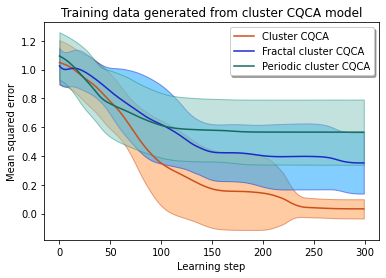

Converged losses:

     Cluster CQCA: 0.033262886106967926 +/- 0.06656419485807419;
		 Best: 4.538291875633149e-08; Worst: 0.22418491542339325
     Fractal cluster CQCA: 0.3518851399421692 +/- 0.2124977856874466;
		 Best: 0.07582210004329681; Worst: 0.6703030467033386
     Periodic cluster CQCA: 0.5653932094573975 +/- 0.2261608988046646;
		 Best: 0.08063335716724396; Worst: 0.9399814009666443



In [52]:
NAME_PLOT = 'Training data generated from cluster CQCA model'
NAME_MODELS = ['Cluster CQCA', 'Fractal cluster CQCA', 'Periodic cluster CQCA']
NUM_MODELS = 10
PATHS = ["results_c_learns_c_", 
         "results_cf_learns_c_",
         "results_cp_learns_c_"]


plot_results(PATHS, NAME_MODELS, NUM_MODELS, NAME_PLOT)

## Fractal cluster CQCA as target

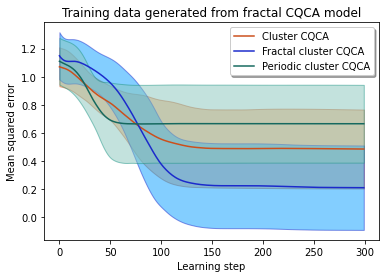

Converged losses:

     Cluster CQCA: 0.48551589250564575 +/- 0.2811009883880615;
		 Best: 0.07043250650167465; Worst: 1.0209673643112183
     Fractal cluster CQCA: 0.2102842628955841 +/- 0.3005068302154541;
		 Best: 2.5928425628762852e-08; Worst: 0.8954996466636658
     Periodic cluster CQCA: 0.665521502494812 +/- 0.2767711579799652;
		 Best: 0.14579907059669495; Worst: 1.1405925750732422



In [53]:
NAME_PLOT = 'Training data generated from fractal CQCA model'
NAME_MODELS = ['Cluster CQCA', 'Fractal cluster CQCA', 'Periodic cluster CQCA']
NUM_MODELS = 10
PATHS = ["results_c_learns_cf_", 
         "results_cf_learns_cf_",
         "results_cp_learns_cf_"]


plot_results(PATHS, NAME_MODELS, NUM_MODELS, NAME_PLOT)

## Periodic cluster CQCA as target

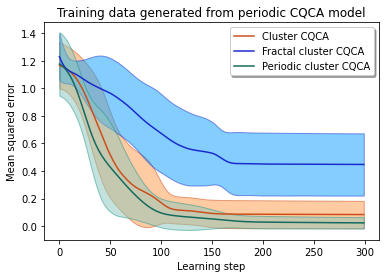

Converged losses:

     Cluster CQCA: 0.0838826447725296 +/- 0.09911832958459854;
		 Best: 0.002436721697449684; Worst: 0.3105243742465973
     Fractal cluster CQCA: 0.4472268223762512 +/- 0.2257121503353119;
		 Best: 0.13689406216144562; Worst: 0.7969082593917847
     Periodic cluster CQCA: 0.02342287078499794 +/- 0.0413689911365509;
		 Best: 8.022944530239329e-05; Worst: 0.1413067877292633



In [54]:
NAME_PLOT = 'Training data generated from periodic CQCA model'
NAME_MODELS = ['Cluster CQCA', 'Fractal cluster CQCA', 'Periodic cluster CQCA']
NUM_MODELS = 10
PATHS = ["results_c_learns_cp_", 
         "results_cf_learns_cp_",
         "results_cp_learns_cp_"]


plot_results(PATHS, NAME_MODELS, NUM_MODELS, NAME_PLOT)